# Cross Validation of radial distribution function (RDF)

Here we calculate the RDF using a particle code and a grids code and compared the results to validate the correctness of the grid code

## Method
The RDF is computed from the radially binned particle counts obtained using the particleTurbulence code by Natascha (https://github.com/nManger/particleTurbulenceAnalysis). The way I do it is as follows:

Recall the RDF is related to the particle count $dn(\mathbf{r})$ in a volume $d^3\mathbf{r}$ as follows:

\begin{align*}
\bar{n} g(\mathbf{r}) d^3\mathbf{r} = dn(\mathbf{r})
\end{align*}

If the system is isotropic, we can estimate the RDF by radial binning:

\begin{align*}
g(r) \approx \frac{\int_\text{shell} dn}{ \bar{n}\int_\text{shell} d^3 \mathbf{r}} = \frac{N_\text{shell}}{4\pi r^2 \Delta r \bar{n}}
\end{align*}

where $N$ is the number of particles in each bin and $r$ is the radius (bin center) and $\bar{n}$ is the average density of the whole dust distribution. We shall estimate the last one by averaging the number of particles over the ball of radius = binEdges[-1]

Another way to look at the RDF is to start with the formula:
\begin{align*}
g(r) \approx \frac{\int_\text{shell} dn}{ \bar{n}\int_\text{shell} d^3 \mathbf{r}} \approx \frac{\bar{n}_\text{shell}}{\bar{n}}
\end{align*}
This can be usedful when calculating things directly using a pairwise approach

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
stat_json = open('./data/RDFVelocityTest.json')
stats = json.load(stat_json)

In [3]:
binEdges = np.array(stats['binEdges'])
binCenters = np.array(stats['binCenters'])
partCounts = np.array(stats['partCounts'])
dr = binEdges[1:]-binEdges[:-1]

In [7]:
n_bar = np.sum(partCounts)/((4/3)*np.pi*binEdges[-1]**3)
rdf = partCounts/(4*np.pi*binCenters**2*dr)/n_bar

In [88]:
def R2_like(field):
    axes = [np.fft.fftfreq(dim,d=1/dim) for dim in field.shape]
    if len(axes) == 3:
        axes=axes[0][:,None,None],axes[1][None,:,None],axes[2][None,None,:]
    else:
        axes=axes[0][:,None],axes[1][None,:]
    return np.sum(np.array([ax**2 for ax in axes],dtype=object)) # Create radial axes

def radial_binning(field,bin_count=30): # Give radial average of field. Assume input field unshifted
    R = np.sqrt(R2_like(field))
    
    bin_edges = np.geomspace(1,0.1*256,bin_count+1)
    
    radial_bin, edges, _ = stats.binned_statistic(R.flatten(),field.flatten(),statistic='mean',bins=bin_edges)
    rs = np.sqrt(edges[1:]*edges[:-1])
    #print(rs)
    return rs,radial_bin

In [89]:
grid_dcf = np.load('./dcf_fft.npy')
rs, grid_rdf = radial_binning(1+grid_dcf)
grid_rdf_out = np.load('./grid-rdf-out.npy')

In [90]:
#rs,grid_rdf

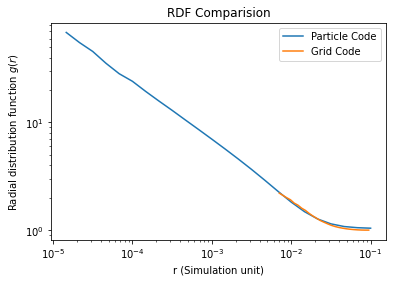

In [91]:
plt.title('RDF Comparision')
plt.loglog(binCenters,rdf,label='Particle Code')
plt.loglog(rs/256,grid_rdf,label='Grid Code')
plt.xlabel('r (Simulation unit)')
plt.ylabel('Radial distribution function $g(r)$')
plt.legend()

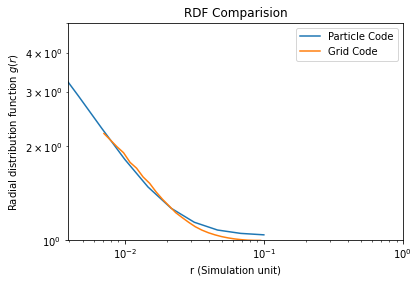

In [92]:
plt.title('RDF Comparision')
plt.loglog(binCenters,rdf,label='Particle Code')
plt.loglog(rs/256,grid_rdf,label='Grid Code')
plt.xlabel('r (Simulation unit)')
plt.ylabel('Radial distribution function $g(r)$')
plt.xlim(1/256,1)
plt.ylim(1,5)
plt.legend()

## Conclusion
It seems like the grid code is at least calculating things correctly (by their shape). The grid code produce RDF lower than the particle code when $r\approx \text{GridSize} = 1/256 \approx 10^{-2}$. This might be an artifact of radial averaging of the grid code. Specifically, because the smallest averaging volume is of grid size, any qunatities that change sufficiently rapidly in that length scale will smear out. This might explain why the value is smaller closer to grid scale